# **Импорт библиотек**

In [316]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


from skimage import io
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# **Препроцессинг изображений, создание датасетов**

In [317]:
train_data_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.1,
                                          rotation_range=0.1)

test_data_generator = ImageDataGenerator(rescale=1./255)

val_data_generator = ImageDataGenerator(rescale=1./255)

In [339]:
train_ds = train_data_generator.flow_from_directory(
    "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train",
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='binary',
    classes = ["WithoutMask","WithMask"],
    batch_size=32,
    seed=123
)

test_ds = test_data_generator.flow_from_directory(
    "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test",
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='binary',
    classes = ["WithoutMask","WithMask"],
    batch_size=32,
    seed=123
)

val_ds = val_data_generator.flow_from_directory(
    "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation",
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='binary',
    classes = ["WithoutMask","WithMask"],
    batch_size=32,
    seed=123
)

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# **Создание модели**

In [340]:
model = Sequential([
    #layers.InputLayer(input_shape=(128,128,1)),
    
    layers.Conv2D(32, 2, padding='same', activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D(pool_size=(2)),
    
    layers.Conv2D(64, 4, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2)),
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation = "sigmoid")
])

In [341]:
model.compile(optimizer=Adam(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])

In [342]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 128, 128, 32)      160       
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 64, 64, 64)        32832     
                                                                 
 max_pooling2d_50 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_22 (Flatten)        (None, 65536)             0         
                                                                 
 dense_44 (Dense)            (None, 64)              

# **Обучение модели**

In [343]:
reducer = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, min_delta=0.0001, verbose=1)
stopper = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001, mode='max')
checkpoint = ModelCheckpoint('face_mask_detect_model.keras', monitor='val_accuracy', mode='max')

In [344]:
model.fit(batch_size=32,
        epochs=10,
        x=train_ds,
        validation_data=test_ds,
        callbacks = [reducer, stopper, checkpoint],
        verbose=1)

Epoch 1/10
313/313 [==============================] - 38s 117ms/step - loss: 0.2073 - accuracy: 0.9105 - val_loss: 0.0730 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 2/10
313/313 [==============================] - 36s 114ms/step - loss: 0.0852 - accuracy: 0.9716 - val_loss: 0.0723 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 3/10
313/313 [==============================] - 36s 115ms/step - loss: 0.0644 - accuracy: 0.9781 - val_loss: 0.0465 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 4/10
313/313 [==============================] - 36s 114ms/step - loss: 0.0541 - accuracy: 0.9806 - val_loss: 0.0704 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 5/10
313/313 [==============================] - 35s 112ms/step - loss: 0.0533 - accuracy: 0.9808 - val_loss: 0.0588 - val_accuracy: 0.9788 - lr: 0.0010
Epoch 6/10
313/313 [==============================] - 36s 113ms/step - loss: 0.0470 - accuracy: 0.9846 - val_loss: 0.0370 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 7/10
313/313 [==============================] 

In [324]:
model.evaluate(val_ds)

31/31 [==============================] - 2s 58ms/step - loss: 0.0401 - accuracy: 0.9879


[0.04007180407643318, 0.9879032373428345]

# **Предсказания**

**Человек в маске**

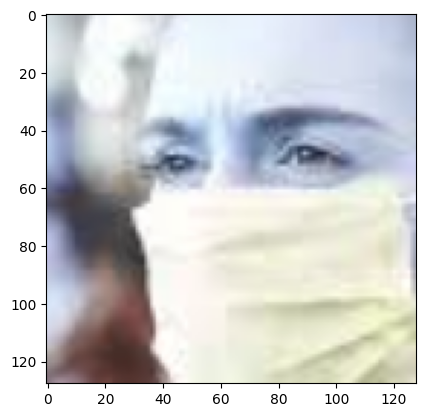

In [345]:
sample_mask_img = cv2.imread('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/1007.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = cv2.cvtColor(sample_mask_img, cv2.COLOR_BGR2GRAY)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,1])
sample_mask_img = sample_mask_img/255.0

In [346]:
model.predict(sample_mask_img)

1/1 [==============================] - 0s 64ms/step


array([[0.9986058]], dtype=float32)

**Человек без маски**

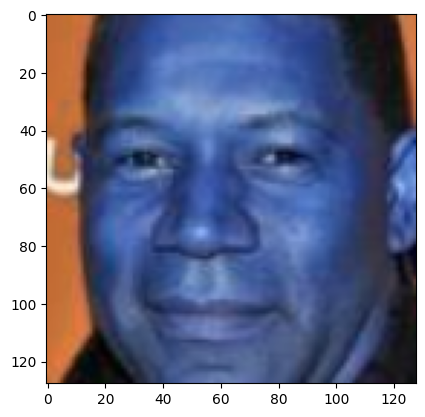

In [347]:
sample_nomask_img = cv2.imread('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask/1008.png')
sample_nomask_img = cv2.resize(sample_nomask_img,(128,128))
plt.imshow(sample_nomask_img)
sample_nomask_img = cv2.cvtColor(sample_nomask_img, cv2.COLOR_BGR2GRAY)
sample_nomask_img = np.reshape(sample_nomask_img,[1,128,128,1])
sample_nomask_img = sample_nomask_img/255.0

In [348]:
model.predict(sample_nomask_img)

1/1 [==============================] - 0s 19ms/step


array([[0.00153316]], dtype=float32)

# **Распознавание лиц на изображении**

In [362]:
face_classifier = cv2.CascadeClassifier('/kaggle/input/haarcascades/haarcascade_frontalface_alt.xml')

def detect_faces(img):
    gray = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    
    faces = face_classifier.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=4,
    minSize=(10, 10),
    )
    
    return faces

In [363]:
def draw(img, face):
    (x,y,w,h) = face
    mask_label = {0:'NO MASK!',1:'Mask'}
    label_color = {0: (255,0,0), 1: (0,255,0)}
    
    crop = img[y:y+h,x:x+w]
    
    crop = cv2.resize(crop,(128, 128))
    crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    crop = np.reshape(crop,[1,128,128,1]) / 255.0
    
    mask_result = model.predict(crop)
            
    pred_label = round(mask_result[0][0])
            
    cv2.putText(img,mask_label[pred_label],
                (x, y+90), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, label_color[pred_label], 2)
            
    cv2.rectangle(img,(x,y),(x+w,y+h), 
                label_color[pred_label],1)
    
    return img

In [364]:
def detect_mask(path): 
    img = io.imread(path)
    faces = detect_faces(img)
    
    if len(faces)>=1:
        for i in range(len(faces)):
            Draw(img, faces[i])
                        
        plt.figure(figsize=(16,14))
        plt.imshow(img)
            
    else:
        print("No Face!")

1/1 [==============================] - 0s 19ms/step
[[0.58746487]]
1/1 [==============================] - 0s 18ms/step
[[0.99952745]]
1/1 [==============================] - 0s 18ms/step
[[0.00045893]]
1/1 [==============================] - 0s 18ms/step
[[0.9999999]]


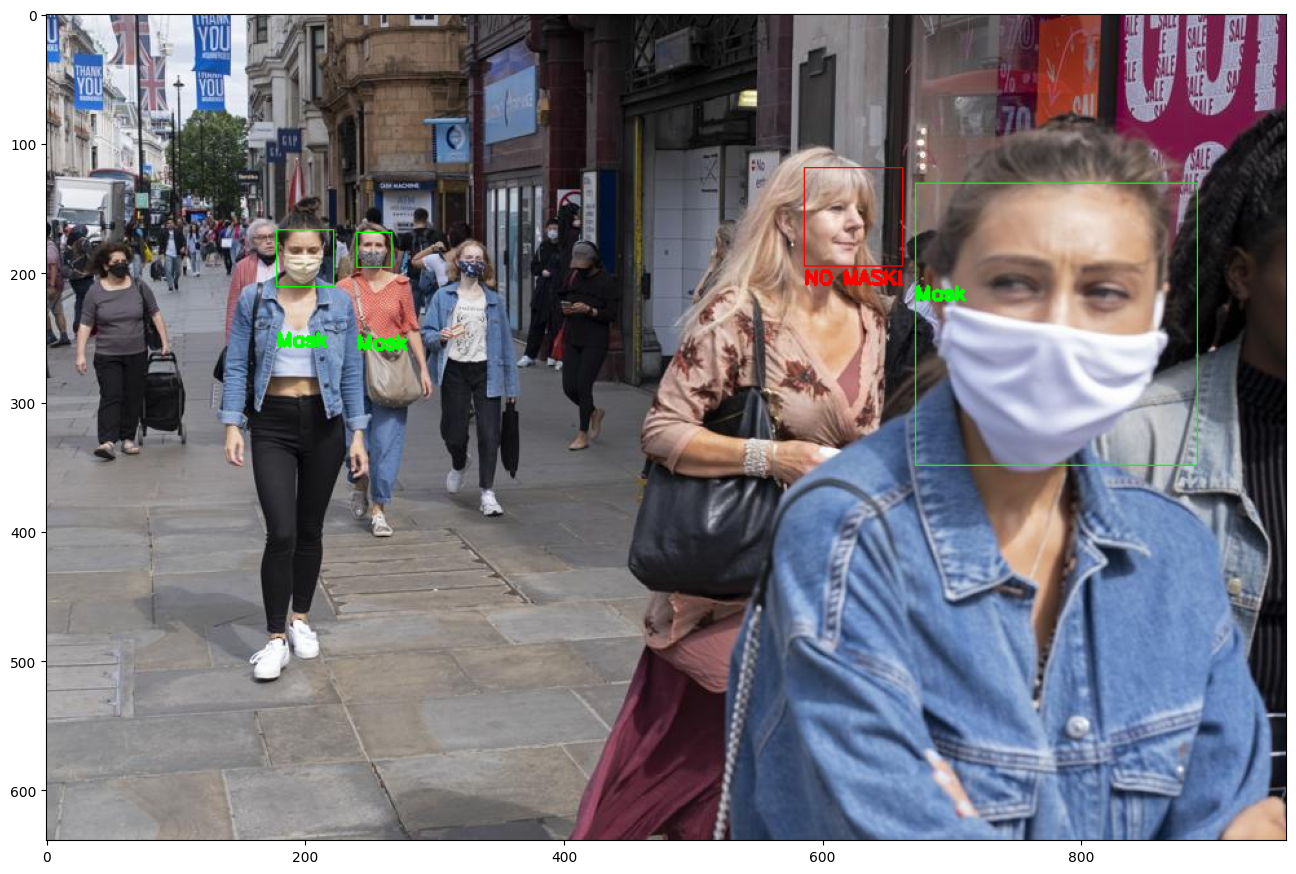

In [365]:
detect_mask("/kaggle/input/faces-test/960x0.jpg")